<a href="https://colab.research.google.com/github/pmaher86/nyc_rooftop_topography/blob/main/NYC_Rooftop_Topography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topographic Mapping of New York City Rooftops
### Patrick Maher
### [Open Data Week 2022](https://2022.open-data.nyc/)
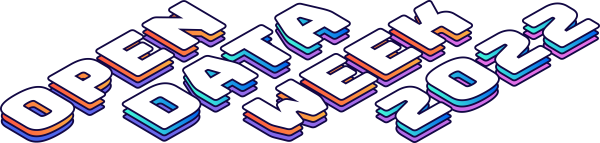

Topographic maps plot contours of equal height, allowing the user to easily see changes in elevation. They're a common way of visualzing natural terrain. For this exercise, we'll explore how we can use the concept of topographic mapping to visualize the unique man-made terrain of New York City by incorporating the heights of buildings into our maps.

We'll do this using a number of scientific and geospatial tools in Python. We'll see how to work with large datasets, how to combine vector and raster information, and how to generate high-resolution plots of the city's unique topography.


# Download data 

We'll start by downloading our data. The main datasets we'll be using are the [NYC 1 Foot Digital Elevation Model](https://data.cityofnewyork.us/City-Government/1-foot-Digital-Elevation-Model-DEM-/dpc8-z3jc) and the [Building Footprints](https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh) dataset.

In [1]:
!curl "https://sa-static-customer-assets-us-east-1-fedramp-prod.s3.amazonaws.com/data.cityofnewyork.us/NYC_DEM_1ft_Int.zip" --output lidar.zip
!unzip lidar.zip
!rm lidar.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3067M  100 3067M    0     0  58.7M      0  0:00:52  0:00:52 --:--:-- 60.0M
Archive:  lidar.zip
  inflating: DEM_LiDAR_1ft_2010_Improved_NYC_int.tfw  
  inflating: DEM_LiDAR_1ft_2010_Improved_NYC_int.tif  
  inflating: DEM_LiDAR_1ft_2010_Improved_NYC_int.tif.aux.xml  
  inflating: DEM_LiDAR_1ft_2010_Improved_NYC_int.tif.xml  


In [2]:
!curl "https://data.cityofnewyork.us/api/geospatial/nqwf-w8eh?method=export&format=Original" --output building_footprints.zip
!unzip building_footprints.zip
!rm building_footprints.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198M    0  198M    0     0  16.5M      0 --:--:--  0:00:12 --:--:-- 17.0M
Archive:  building_footprints.zip
  inflating: building_p.shp.xml      
  inflating: building.shp.xml        
  inflating: building.dbf            
  inflating: building.prj            
  inflating: building.shp            
  inflating: building.shx            
  inflating: building_p.dbf          
  inflating: building_p.prj          
  inflating: building_p.shp          
  inflating: building_p.shx          


In [3]:
!ls -hl

total 4.4G
-rw-r--r-- 1 root root 487M Feb 26 22:09 building.dbf
-rw-r--r-- 1 root root 422M Feb 26 22:09 building_p.dbf
-rw-r--r-- 1 root root  562 Feb 26 22:00 building_p.prj
-rw-r--r-- 1 root root  562 Feb 26 22:00 building.prj
-rw-r--r-- 1 root root  29M Feb 26 22:09 building_p.shp
-rw-r--r-- 1 root root  18K Feb 26 22:09 building_p.shp.xml
-rw-r--r-- 1 root root 8.3M Feb 26 22:09 building_p.shx
-rw-r--r-- 1 root root 207M Feb 26 22:09 building.shp
-rw-r--r-- 1 root root  17K Feb 26 22:09 building.shp.xml
-rw-r--r-- 1 root root 8.3M Feb 26 22:09 building.shx
-rw-r--r-- 1 root root   89 Oct 11  2017 DEM_LiDAR_1ft_2010_Improved_NYC_int.tfw
-rw-r--r-- 1 root root 3.2G Oct 11  2017 DEM_LiDAR_1ft_2010_Improved_NYC_int.tif
-rw-r--r-- 1 root root 4.9K Oct 16  2017 DEM_LiDAR_1ft_2010_Improved_NYC_int.tif.aux.xml
-rw-r--r-- 1 root root  654 Oct 16  2017 DEM_LiDAR_1ft_2010_Improved_NYC_int.tif.xml
drwxr-xr-x 1 root root 4.0K Feb 18 14:33 sample_data


The first thing we notice about this data is that it's pretty big! The `building.shp` file contains outlines of every structure in NYC. It's 207 MB, which is big enough that working with it all once will be slow. We can also see that the Digital Elevation Model is big—a 3.2 GB .tif! This is too much for us to easily load in memory at once. In order to work with data efficiently, we'll have to be careful about what we load into memory when.

# Install dependencies

The Colab environment comes with a lot of the scientific libraries we need preinstalled, but we'll install a couple more that will be useful.

In [4]:
!pip install fiona pyproj llc geopandas pygeos

     |████████████████████████████████| 16.7 MB 435 kB/s 
     |████████████████████████████████| 6.3 MB 62.4 MB/s 
     |████████████████████████████████| 1.0 MB 57.0 MB/s 
     |████████████████████████████████| 2.1 MB 64.5 MB/s 


# Prepare Python environment

We'll begin by importing all the packages we'll need for this exercise—I'll explain what they do as we go.



In [5]:
from typing import Callable, Optional, Tuple

import geopandas
import gdal
import fiona
import matplotlib.pyplot as plt
import numpy as np
import osgeo
import pandas as pd
import plotly.graph_objects as go
import pyproj
import shapely

from llc import jit_filter_function
from scipy.interpolate import interp2d
from scipy.ndimage import generic_filter
from tqdm.auto import tqdm


/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Visualizing the Digital Elevation Map

The first thing we want to do is look at the digital elevation map. This map is what we call [raster data](https://en.wikipedia.org/wiki/Raster_graphics), meaning it's stored as a grid of values. Because the image is so large, we can't just load it into memory and work with it. We'll use a library called [gdal](https://gdal.org/api/python.html), which will allow us to define transformations on the image, and then do the computation in a streaming manner when we ask for a result.

In [6]:
geotiff = gdal.Open("DEM_LiDAR_1ft_2010_Improved_NYC_int.tif")

In [7]:
print(f"Resolution: ({geotiff.RasterXSize}, {geotiff.RasterYSize})")

Resolution: (158100, 156100)


Indeed, this is a big image! We'll scale it down to 500 px in width, which will be much more manageable to work with.

In [8]:
scaled_geotiff = gdal.Warp("", geotiff, format="vrt", width=500)

When working with geospatial data, it's important to be aware of what coordinate system we're using, and (relatedly) what projection we're using. While latitude and longitude are the most familiar coordinate systems, they're not very good for raster maps like our elevation map, because the units of latitude and longitude don't correspond to a consitent measure of physical area. Instead, an alternative called [easting and northing](https://en.wikipedia.org/wiki/Projected_coordinate_system#Easting-Northing) is very convenient. These coordinates make it so that pixels in our image are all the same size.

Spefically, this data comes in the NAD83 / New York Long Island State Plane coordinate system, and our units of measurement will be in feet.

In [9]:
scaled_geotiff.GetProjection()

'PROJCS["NAD83 / New York Long Island (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221008872,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",41.03333333333333],PARAMETER["standard_parallel_2",40.66666666666666],PARAMETER["latitude_of_origin",40.16666666666666],PARAMETER["central_meridian",-74],PARAMETER["false_easting",984250.0000000002],PARAMETER["false_northing",0],UNIT["US survey foot",0.3048006096012192,AUTHORITY["EPSG","9003"]],AUTHORITY["EPSG","2263"]]'

In order to construct the grid of coordinates for each pixel in our image, we'll need to use the `GetGeoTransform` function, which returns information about the specifics of the image (see [here](https://gdal.org/tutorials/geotransforms_tut.html)).

In [10]:
def get_coordinate_arrays(gdal_image: osgeo.gdal.Dataset) -> Tuple[np.ndarray, np.ndarray]:
  (x_origin, x_px, x_rot, y_origin, y_rot, y_px) = gdal_image.GetGeoTransform()
  # assuming x_rot, y_rot are zero
  x_coords = x_origin + x_px * np.arange(gdal_image.RasterXSize)
  y_coords = y_origin + y_px * np.arange(gdal_image.RasterYSize)
  return x_coords, y_coords


In [11]:
dem = scaled_geotiff.ReadAsArray()
dem_x, dem_y = get_coordinate_arrays(scaled_geotiff)

We'll use [matplotlib](https://matplotlib.org/) to do the bulk of our plotting—it's a workhorse of the Python scientific ecosystem, and very flexible. There are more specialized geospatial libraries out there, but matplotlib will allow us to easily make some cool contour plots with customized color scales.

In [12]:
def topographic_map(
  x: np.ndarray,
  y: np.ndarray, 
  raster_image: np.ndarray, 
  figsize: Tuple[int,int] = (10,10),
  num_levels: int = 20,
  filled: bool = False, 
  colorbar: bool= False, 
  max_val: Optional[float] = None, 
) -> plt.Figure:
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)
  cmap = plt.get_cmap('terrain')
  if not max_val:
    max_val = np.nanmax(raster_image)
  levels = [0, 5] + list(np.linspace(0, max_val, num_levels)[1:])
  colors = [cmap(0)] + [cmap(0.25 + 0.75 * (l / max_val)) for l in levels[1:]]
  if filled:
    contours = ax.contourf(x, y, raster_image, colors=colors, levels=levels)
  else:
    contours = ax.contour(x, y, raster_image, colors=colors, levels=levels)
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  ax.set_aspect('equal')
  if colorbar:
    fig.colorbar(contours)
  return fig


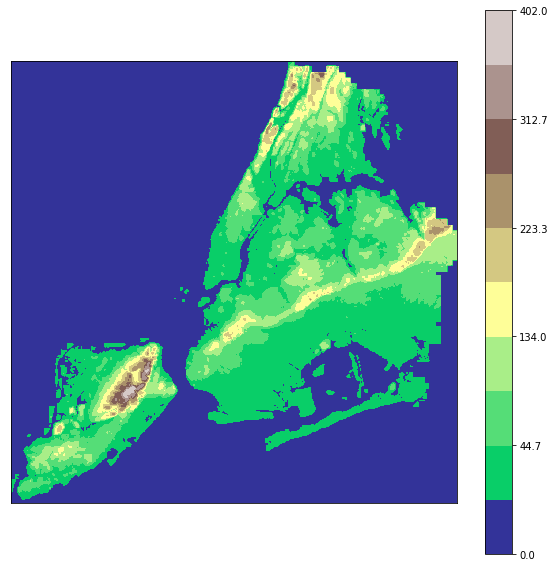

In [13]:
fig = topographic_map(dem_x, dem_y, dem, filled=True, colorbar=True, num_levels=10)

Some of these geographic features might be surprising! Did you know that there was such a promiment ridge running through Brooklyn and Queens? Or that the [point of highest natural elevation](https://en.wikipedia.org/wiki/Todt_Hill) in all of NYC was in Staten Island?

We can alternaltely make similar plots with the [plotly](https://plotly.com/python/) library. It's not quite as flexible as matplotlib for customizing our styling, and because it's based on javascript, it won't handle very high resolution data as well. But the upside is that the plots are interactive inside our notebook.

In [14]:
def rgba_to_string(rgba:Tuple[float, float, float, float]) -> str:
  return 'rgb({}, {}, {})'.format(*[int(x * 255) for x in rgba[:3]])

def plotly_topographic_map(
  x: np.ndarray,
  y: np.ndarray, 
  raster_image: np.ndarray, 
  height_px: int = 800, 
  width_px: int = 800, 
  num_levels: int = 20, 
  max_val: Optional[float] = None,
) -> go.Figure:
  cmap = plt.get_cmap('terrain')
  if not max_val:
    max_val = np.nanmax(raster_image)
  levels = [0, 5] + list(np.linspace(0, max_val, num_levels)[1:])
  colors = [[0, rgba_to_string(cmap(0))]] + [
      [l / max_val, rgba_to_string(cmap(0.25 + 0.75 * (l / max_val)))] for l in levels[1:]
    ]
  contours = dict(
      start=5, 
      end=max_val, 
      size=int(max_val / num_levels),
  )
  fig = go.Figure(
      data=go.Contour(
          x=x, 
          y=y, 
          z=raster_image,
          colorscale=colors,
          contours=contours,
          line_smoothing=1,
          line=dict(width=0)
      ), 
      layout=go.Layout(
          xaxis=dict(showticklabels=False),
          yaxis=dict(scaleanchor="x", scaleratio=1, showticklabels=False), 
          width=width_px,
          height=height_px,
      ),
      
  )
  return fig

In [15]:
plotly_topographic_map(dem_x, dem_y, dem, num_levels=10)

# Working with Building Height Data

The LIDAR data gives us a great picture of the city's innate elevation, but it's pretty different than how humans typically perceive it. It's hard to to imagine what the landscape of New York without taking into account the skyline! So let's start incorporating some building data and see if we can make some maps that reflect that.



## Loading a shapefile

First, we'll start by loading the shapefile which contains the height of every building and it's location, represented by a coordinate point. We'll use the simpler point representations for now, because when we're mapping the whole city it won't make much difference whether we're using points or polygons.

We'll use [fiona](https://github.com/Toblerity/Fiona) to read the data, and store it in a pandas dataframe. Because this kind of read can take a while with bigger datasets, we'll a neat utility called [tqdm](https://tqdm.github.io/) to monitor the progress.

In [16]:
with fiona.open('building_p.shp', 'r') as shapes:
  shape_data = [
    {
      'x': s['geometry']['coordinates'][0],
      'y': s['geometry']['coordinates'][1],
      'ground_to_roof': s['properties']['HEIGHTROOF'], 
      'ground_elev': s['properties']['GROUNDELEV'],
    } for s in tqdm(shapes)
  ]

df = pd.DataFrame(shape_data)

  0%|          | 0/1084412 [00:00<?, ?it/s]

In [17]:
df.head()

x              y  ground_to_roof  ground_elev
0  9.934847e+05  167354.974723       29.749853         40.0
1  9.376381e+05  172243.419586       22.630000         39.0
2  9.300139e+05  141940.011610       35.760000         51.0
3  9.950380e+05  149647.267954       37.500000          6.0
4  1.052324e+06  214746.411108       18.015113         93.0

Our `ground_to_roof` and `ground_elev` columns are in feet, and have an obvious meaning. What about our `x` and `y` coordinates, though? These are the easting and northing discussed earlier. We can make use of [pyproj](https://pyproj4.github.io/pyproj/stable/) to translate between coordiate systems, and see what these points look like in familiar latitude and longitude.

In [18]:
data_projection = pyproj.crs.CRS.from_wkt(scaled_geotiff.GetProjection())
data_projection

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- E[east]: Easting (US survey foot)
- N[north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [19]:
latlon_projection = pyproj.crs.CRS(4326)
data_to_latlon = pyproj.Transformer.from_crs(
    crs_from=data_projection, crs_to=latlon_projection
)
data_to_latlon.transform(df.loc[0, 'x'], df.loc[0, 'y'])

(40.626022404070646, -73.96673233583692)

## Gridding
Now that we have our building heights loaded, we have to deal with the fact that the building locations are vector data, while our elevation map is raster data. In order to combine them effectively, we'll have to convert one dataset to the type of the other. Since we eventually want to build map images, it makes sense to convert out building heights to a raster dataset. 

Doing this requires some care. A typical way to convert vector data to raster is by creating an evenly spaced grid of points, and sampling the vector data at those points. But because we're interested in capturing the tallest buildings, we want to make sure that every point is considered. Therefore, we'll build a grid and use a `groupby` operation to take the maximum building height for every grid point. Pandas makes this easy to accomplish.

In [20]:
grid_size = 200 # feet
df['x_grid'] = (df['x'] / grid_size).astype(int) * grid_size
df['y_grid'] = (df['y'] / grid_size).astype(int) * grid_size
df['roof_elev'] = df['ground_to_roof'] + df['ground_elev']

In [21]:
max_df = df.groupby(['x_grid','y_grid'], as_index=False)['roof_elev'].max()
max_df['x_ind'] = (max_df['x_grid'] - max_df['x_grid'].min()) // grid_size
max_df['y_ind'] = (max_df['y_grid'] - max_df['y_grid'].min()) // grid_size
max_df.head()

x_grid  y_grid  roof_elev  x_ind  y_ind
0  913200  124000      64.08      0     16
1  913200  124200      53.18      0     17
2  913200  124400      51.42      0     18
3  913400  122200      15.00      1      7
4  913400  123200      55.07      1     12

We now have the tallest rooftop elevations, and the pixel coordinates that they correspond to. We can take this sparsely-formatted data and transform it into a matrix using numpy's indexing syntax. Any pixels that don't have a building associated with them will be `NaN`-valued. Note that there's an important subtlety that comes up in this context: we're used to expressing coordinates in (x, y) order, but matrices are usually indexed by (row, column). This can get confusing, but here it means we need to put our y-coordinate first!

In [22]:
heights = np.full((max_df.y_ind.max() + 1, max_df.x_ind.max() + 1), np.nan)
heights[max_df['y_ind'], max_df['x_ind']] = max_df['roof_elev']

Finally, we can construct the x and y axes in our coordinate system that correspond to our heights matrix.

In [23]:
heights_x = np.linspace(max_df['x_grid'].min(), max_df['x_grid'].max(), heights.shape[1])
heights_y = np.linspace(max_df['y_grid'].min(), max_df['y_grid'].max(), heights.shape[0])
heights_xm, heights_ym = np.meshgrid(heights_x, heights_y)

Let's take a look at what this data looks like.

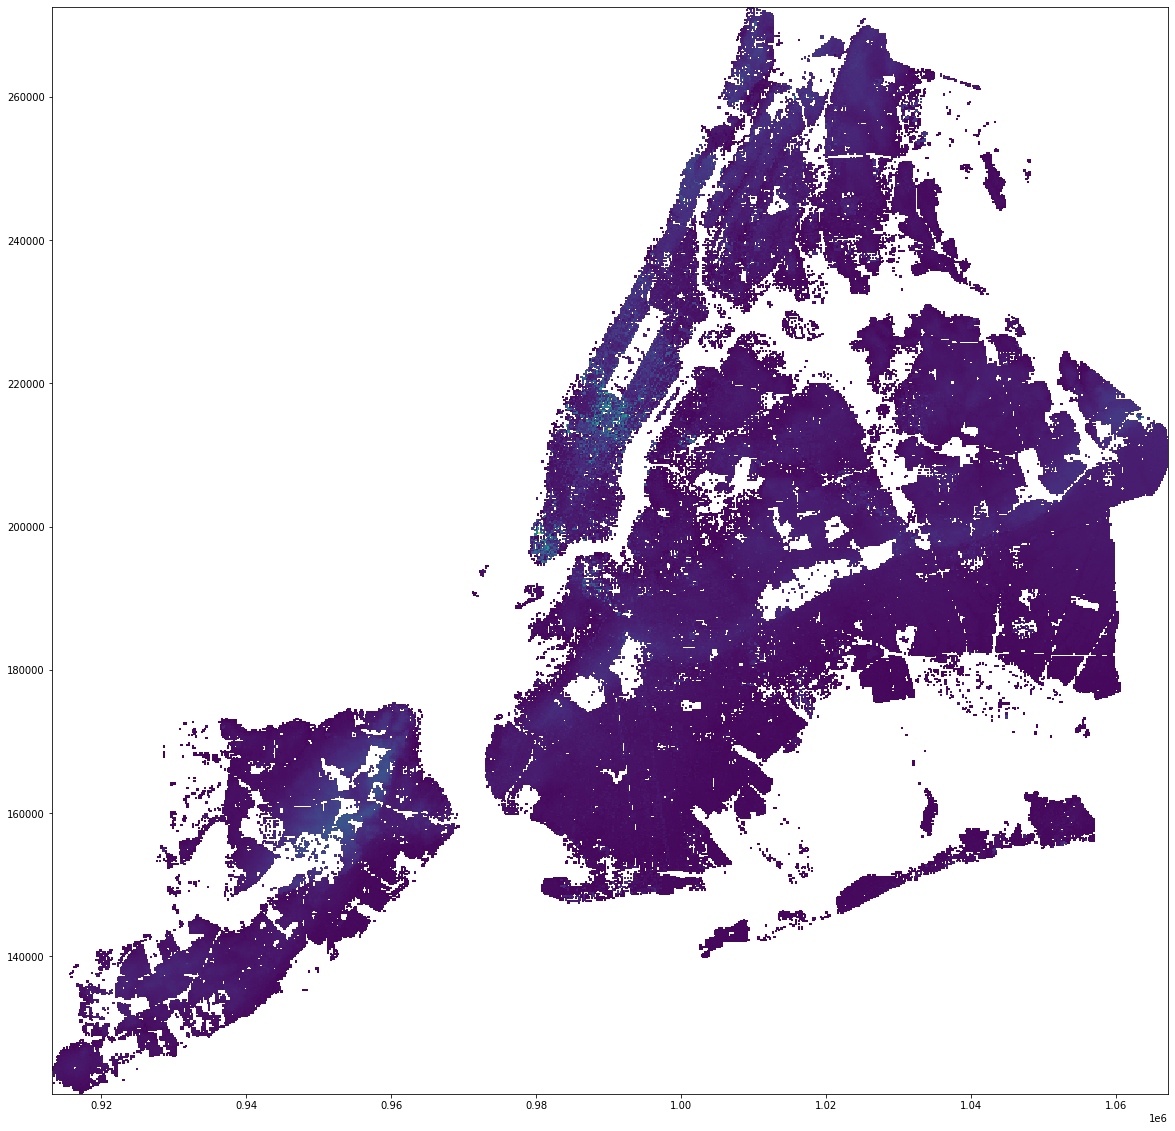

In [24]:
plt.figure(figsize=(20,20))
plt.pcolor(heights_x, heights_y, heights)

## Smoothing
We can see the broad outlines of the city, as buildings densely cover the land in NYC. And we see some colors indicating taller buildings in Manhattan. There's a few issues we need to handle, though. One is that there are still gaps in the data for things like streets and parks. Also, we might have short buildings right next to tall buildings—we'd like the tall buildings to stand out and dominate their surrounding, like they do in our human perception. 

We can accomplish both goals by defining a custom smoothing operation. We'll use something called a smoothing kernel, and combine this with a `max` operation so that we're not just averaging, but preserving the heights of individual buildings.

In [25]:
kernel_size = 15
max_distance = kernel_size // 2
kernel_coords = np.arange(-max_distance, max_distance + 1)
kernel_x, kernel_y = np.meshgrid(kernel_coords, kernel_coords)
distance_kernel = np.sqrt(kernel_x**2 + kernel_y**2)
smooth_kernel = (1 - (distance_kernel / max_distance))
smooth_kernel[distance_kernel > max_distance] = 0

@jit_filter_function
def height_smooth(window):
  window = window.reshape((kernel_size, kernel_size))
  return max(np.nanmax(smooth_kernel * window), window[kernel_size//2, kernel_size//2])

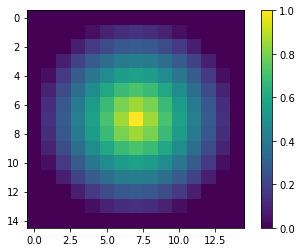

In [26]:
plt.imshow(smooth_kernel)
plt.colorbar()

Now we can apply our smoothing, and see what the data looks like.

In [27]:
smoothed_heights = generic_filter(heights, height_smooth, size=kernel_size, mode='constant', cval=np.nan)

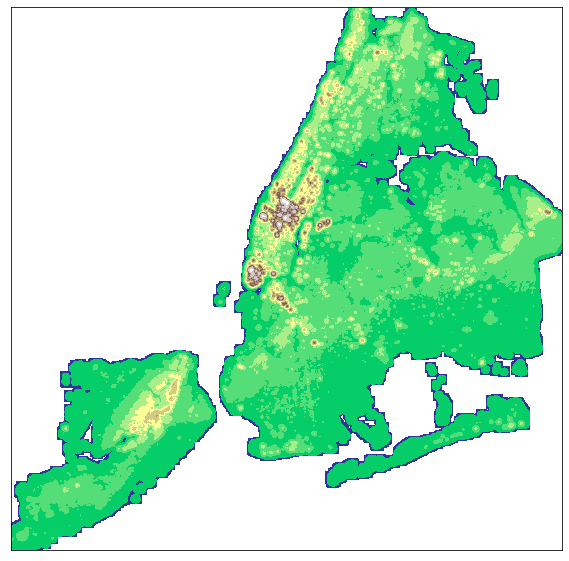

In [28]:
map = topographic_map(heights_x, heights_y, smoothed_heights, figsize=(10,10), num_levels=10, max_val=800, filled=True)

This is staring to look better! We can see Midtown and the Financial District pop out like we'd expect, as well as some other promiment urban features. However, our smoothing has blurred our geographic outlines a bit. We also need to fill in all the missing data. Where there are no buildings nearby. We can accomplish this by going back to digital elevation map. Using scipy, we can easily do some interpolation to get the correct LIDAR elevation in the coordinates of our new image.

In [29]:
interp_fn = interp2d(dem_x, dem_y, dem)
interp_ground_elev = interp_fn(heights_x, heights_y)

In [30]:
filled_smoothed_heights = np.nan_to_num(smoothed_heights, nan=0)
filled_smoothed_heights[interp_ground_elev<=0]=0

## Finished plots
And voila! We're ready to plot a topographic map of New York City, rooftops and all!

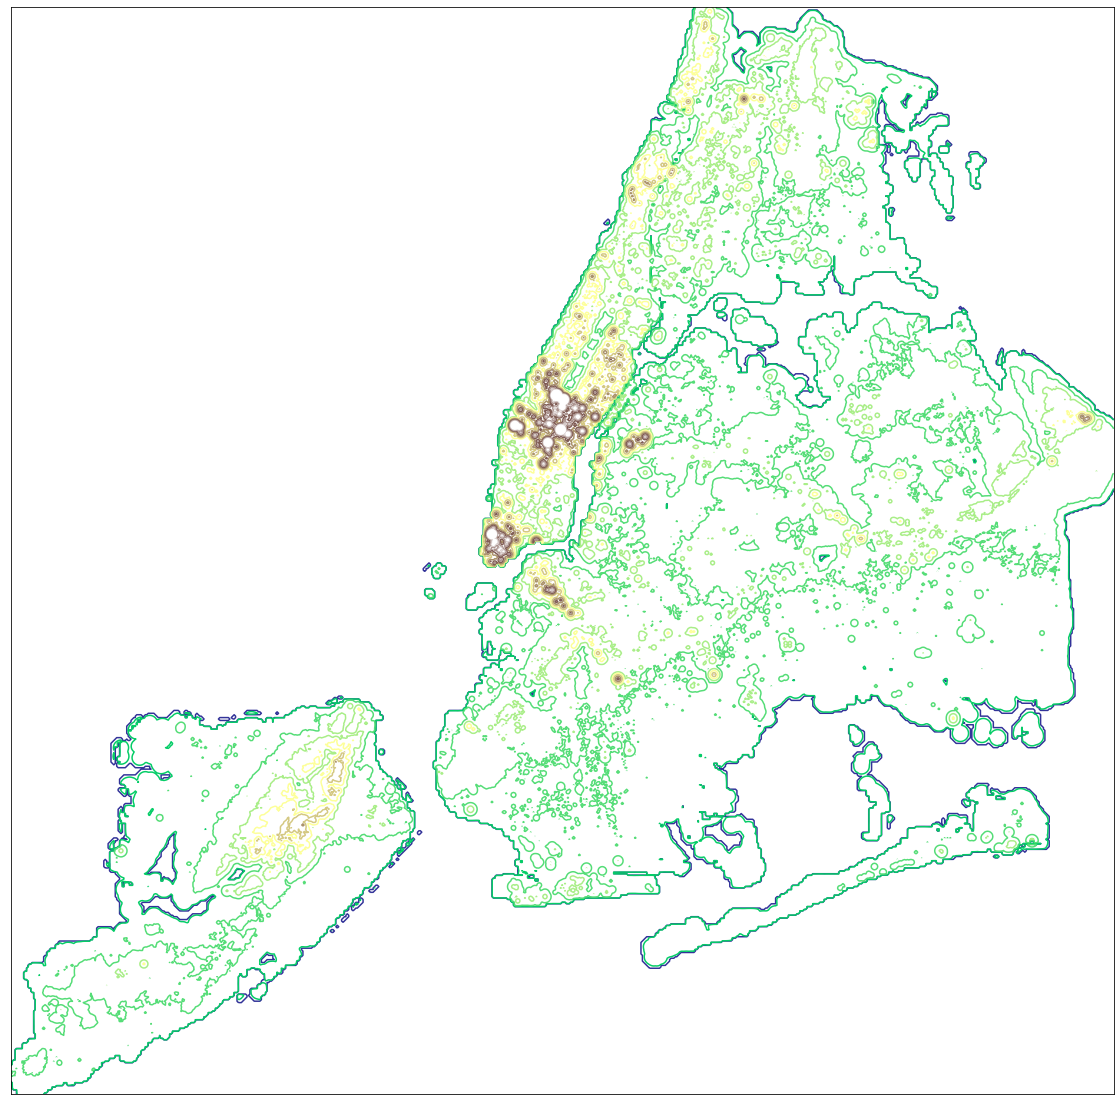

In [31]:
map = topographic_map(heights_x, heights_y, filled_smoothed_heights, figsize=(20,20), num_levels=10, max_val=800, filled=False)

In [32]:
plotly_topographic_map(heights_x, heights_y, filled_smoothed_heights, max_val=800)

# Using building shape files

While our approach using point data was great for plotting the entire city, you can see some fine features get lost at that resolution. What if we want to zoom in and create high-resolution maps of smaller areas?

For that, we'll want to use the full building polygon dataset, and [geopandas](https://geopandas.org/en/stable/index.html) will make it really easy to work with this more complicated shape data. We'll start with two lat/lon coordinates that define an area of interest, and load up the relevant data.

In [33]:
small_sw = (40.7682, -73.9834)
small_ne = (40.7971, -73.9490)

In [34]:
latlon_to_data = pyproj.Transformer.from_crs(
    crs_from=latlon_projection, crs_to=data_projection
)
small_sw_feet = latlon_to_data.transform(*small_sw)
small_ne_feet = latlon_to_data.transform(*small_ne)

In [35]:
shape_df = geopandas.read_file('building.shp', bbox=(*small_sw_feet, *small_ne_feet))

In [36]:
shape_df.shape

(7564, 15)

In [37]:
shape_df.head()

NAME      BIN  CNSTRCT_YR  LSTMODDATE   LSTSTATYPE  DOITT_ID  HEIGHTROOF  \
0  None  1045196      1899.0  2017-08-22  Constructed    562430       50.12   
1  None  1031399      1927.0  2017-08-22  Constructed    267454      151.15   
2  None  1044171      1930.0  2017-08-22  Constructed    647203       71.92   
3  None  1041491      1903.0  2017-08-22  Constructed    639733       94.38   
4  None  1034113      1906.0  2017-08-22  Constructed    540815      119.08   

   FEAT_CODE  GROUNDELEV  SHAPE_AREA  SHAPE_LEN    BASE_BBL  MPLUTO_BBL  \
0       2100        39.0         0.0        0.0  1014510146  1014510146   
1       2100        97.0         0.0        0.0  1012000005  1012000005   
2       2100        45.0         0.0        0.0  1014330016  1014330016   
3       2100        65.0         0.0        0.0  1013880008  1013880008   
4       2100        75.0         0.0        0.0  1012520001  1012520001   

   GEOMSOURCE                                           geometry  
0  Photogramm  POLYGON ((996599.223 220421.007, 996572.312 22...  
1  Photogramm  POLYGON ((992178.988 225786.552, 992166.821 22...  
2  Photogramm  POLYGON ((996372.581 220942.809, 996367.427 22...  
3  Photogramm  POLYGON ((993833.902 220871.036, 993810.484 22...  
4  Photogramm  POLYGON ((990814.636 228342.509, 990821.520 22...

Geopandas has a convenient plot function that allows to immediately recognize this area as Central Park and some surroundings.

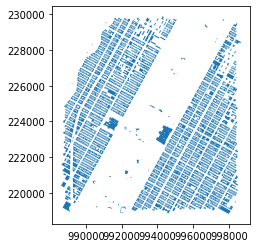

In [38]:
shape_df.plot()

Again, this is vector data, though. We'll need to convert it to raster data if we want to plot it like we did before. Because we're dealing with a finer scale and more complicated shapes, we'll need to do something fancier. We'll build a grid of polygons representing our pixels, and peform a [spatial join](https://geopandas.org/en/stable/gallery/spatial_joins.html) to find which buildings belong in which pixels.

In [39]:
x_grid, step = np.linspace(shape_df.total_bounds[0], shape_df.total_bounds[2], 200, retstep=True)
y_grid = np.arange(shape_df.total_bounds[1], shape_df.total_bounds[3], step)

In [40]:
grid_data = []
for i, x in enumerate(x_grid):
  for j, y in enumerate(y_grid):
    corners = [(x, y), (x+step, y), (x+step, y+step), (x, y+step)]
    grid_data.append({
      'geometry': shapely.geometry.Polygon(corners),
      'x': x,
      'y': y,
      'x_index': i,
      'y_index': j,
    })
grid_df = geopandas.GeoDataFrame(grid_data, crs=shape_df.crs)

In [41]:
grid_df.head()

geometry              x  \
0  POLYGON ((988597.764 218814.566, 988648.403 21...  988597.763602   
1  POLYGON ((988597.764 218865.205, 988648.403 21...  988597.763602   
2  POLYGON ((988597.764 218915.844, 988648.403 21...  988597.763602   
3  POLYGON ((988597.764 218966.484, 988648.403 21...  988597.763602   
4  POLYGON ((988597.764 219017.123, 988648.403 21...  988597.763602   

               y  x_index  y_index  
0  218814.566030        0        0  
1  218865.205191        0        1  
2  218915.844352        0        2  
3  218966.483513        0        3  
4  219017.122675        0        4

In [42]:
shape_df['elev'] = shape_df['HEIGHTROOF'] + shape_df['GROUNDELEV']
joined = shape_df.sjoin(grid_df).groupby(['x_index', 'y_index'], as_index=False)['elev'].max()

In [43]:
small_heights = np.full((len(y_grid), len(x_grid)), np.nan)
small_heights[joined['y_index'], joined['x_index']] = joined['elev']

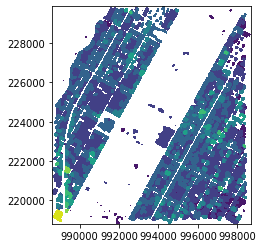

In [44]:
plt.contourf(x_grid, y_grid, small_heights)
plt.gca().set_aspect('equal')

Now that we've seen the outline of how to rasterize the building polygons, let's put together some helper functions that will allow us to plot a nice topographic map, combining the elevation map and the building heights, with our smoothing logic.

In [45]:
def get_dem_cropped_resized(bbox: Tuple[float, float, float, float], width_px:int = 500) -> np.ndarray:
  geotiff = gdal.Open("DEM_LiDAR_1ft_2010_Improved_NYC_int.tif")
  scaled = gdal.Warp("", geotiff, format="vrt",  width=width_px, outputBounds=bbox)
  dem = scaled.ReadAsArray()
  dem_x, dem_y = get_coordinate_arrays(scaled)
  return dem_x, dem_y, dem

def get_grid_geodf(x_grid: np.ndarray, y_grid: np.ndarray) -> geopandas.GeoDataFrame:
  grid_data = []
  x_step, y_step = np.diff(x_grid).mean(), np.diff(y_grid).mean()
  for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
      corners = [(x, y), (x + x_step, y), (x + x_step, y + y_step), (x, y + y_step)]
      grid_data.append({
        'geometry': shapely.geometry.Polygon(corners),
        # 'x': x,
        # 'y': y,
        'x_index': i,
        'y_index': j,
      })
  return geopandas.GeoDataFrame(grid_data, crs=shape_df.crs)


def get_building_raster(bbox: Tuple[float, float, float, float], x_grid: np.ndarray, y_grid: np.ndarray) -> geopandas.GeoDataFrame:
  df = geopandas.read_file('building.shp', bbox=bbox)
  df['roof_elev'] = df['HEIGHTROOF'] + df['GROUNDELEV']
  grid_df = get_grid_geodf(x_grid, y_grid)
  joined_df = df.sjoin(grid_df)
  max_df = joined_df.groupby(['x_index', 'y_index'], as_index=False)['roof_elev'].max()
  raster = np.full((len(y_grid), len(x_grid)), np.nan)
  raster[max_df['y_index'], max_df['x_index']] = max_df['roof_elev']
  return raster

def get_smoothing_fn(kernel_px: int) -> Callable:
  max_distance = kernel_px // 2
  kernel_coords = np.arange(-max_distance, max_distance + 1)
  kernel_x, kernel_y = np.meshgrid(kernel_coords, kernel_coords)
  distance_kernel = np.sqrt(kernel_x**2 + kernel_y**2)
  smooth_kernel = (1 - (distance_kernel / max_distance))
  smooth_kernel[distance_kernel > max_distance] = 0

  @jit_filter_function
  def height_smooth(window):
    window = window.reshape((kernel_px, kernel_px))
    return max(np.nanmax(smooth_kernel * window), window[kernel_px//2, kernel_px//2])
  
  return height_smooth


def plot_topograhic_window(sw_latlon: Tuple[float, float], ne_latlon: Tuple[float, float], width_px=500, smoothing_px=25) -> go.Figure:
  bbox = (*latlon_to_data.transform(*sw_latlon), *latlon_to_data.transform(*ne_latlon))
  x_grid, y_grid, dem = get_dem_cropped_resized(bbox)
  building_heights = get_building_raster(bbox, x_grid, y_grid)
  smoothing_fn = get_smoothing_fn(smoothing_px)
  smoothed_heights = generic_filter(building_heights, smoothing_fn, size=smoothing_px, mode='constant', cval=np.nan)
  smoothed_heights[np.isnan(smoothed_heights)] = dem[np.isnan(smoothed_heights)]
  smoothed_heights = np.maximum(smoothed_heights, dem)
  smoothed_heights[dem <= 0] = 0
  return topographic_map(x_grid, y_grid, smoothed_heights, filled=True, num_levels=10)





Let's try it out! Note, we're crunching a fair amount of data now, so if you make the window too big or the resolution too high it might take a while or crash.

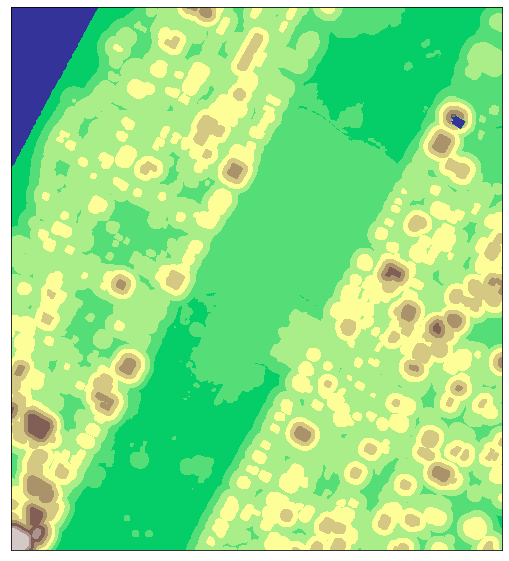

In [46]:
map = plot_topograhic_window((40.7682, -73.9834), (40.7971, -73.9490), smoothing_px=51)

Try looking at your favorite areas of the city, or modifying the code to plot some different NYC data sources. Happy mapping!